## Size Curve Problem

In [10]:
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt

# Load the data
sales = pd.read_csv('https://raw.githubusercontent.com/ben519/sizecurve/master/sales.csv')

#=== Solver ============================================================================================

def get_size_curve(pairs, alpha = 0.0001, iters = 100):
  """
  Given a dataframe of unique variant pairs (v1, v2) and associated
  pairwise sales (n1, n2), return the most likely size curve
  """

  # Copy input dataframe before we muck it up
  pairs2 = pairs.copy()

  # Insert total sales
  pairs2['n'] = pairs2.n1 + pairs2.n2

  # initialize probabilities for every variant
  variants = pd.DataFrame({'variant': pd.unique(pd.concat((pairs2.v1, pairs2.v2)))})
  variants['p'] = 1/len(variants)
  variants.set_index('variant', inplace=True)

  # Gradient ascent
  for i in range(iters):

    # Insert probabilities into pairs2
    pairs2.set_index('v1', inplace=True)
    pairs2['p1'] = variants.p
    pairs2.reset_index(inplace=True)
    pairs2.set_index('v2', inplace=True)
    pairs2['p2'] = variants.p
    pairs2.reset_index(inplace=True)

    # Calculate log likelihood
    pairs2['p12'] = pairs2.p1/(pairs2.p1 + pairs2.p2)
    pairs2['logl'] = pairs2.n1 * np.log(pairs2.p1) + (pairs2.n - pairs2.n1) * np.log(1 - pairs2.p1)
    logl = np.sum(pairs2.logl)

    # Print progress
    print(f'iteration: {i}, log likelihood: {logl}')

    # Calculate the gradient (partial log likelihood / partial p_i)
    pairs2['g1'] = (pairs2.n1/pairs2.p12 - (pairs2.n - pairs2.n1)/(1 - pairs2.p12)) * (pairs2.p2)/(pairs2.p1 + pairs2.p2)**2
    pairs2['g2'] = (pairs2.n1/pairs2.p12 - (pairs2.n - pairs2.n1)/(1 - pairs2.p12)) * (-pairs2.p1)/(pairs2.p1 + pairs2.p2)**2
    grads = pd.concat((
        pairs2[['v1', 'g1']].rename(columns={'v1':'variant', 'g1':'grad'}),
        pairs2[['v2', 'g2']].rename(columns={'v2':'variant', 'g2':'grad'})
    ))
    grads = grads.groupby('variant')[['grad']].sum()

    # Update probabilities (gradient step)
    variants['grad'] = grads['grad']
    variants['p'] = variants.p + alpha * variants.grad
    variants['p'] = variants.p/variants.p.sum()

  return variants[['p']]

#=== Prep the data ============================================================================================

# Generate pairwise data
variants = sales.variant.unique()
variant_pairs = [comb for comb in combinations(variants, 2)]

# For each (v1, v2) pair, count the inventory on days where both v1 and v2 were present,
# and neither was depleted
pairs = []
salesnd = sales.loc[~(sales.depleted)]
for vp in variant_pairs:
  temp = pd.concat((
      salesnd.loc[salesnd.variant == vp[0]],
      salesnd.loc[salesnd.variant == vp[1]]
  ))
  temp['variants'] = temp.groupby('date')['variant'].transform('count')
  temp = temp.loc[temp.variants == 2]
  counts = temp.groupby('variant')['sales'].sum()
  pair = pd.DataFrame({
      'v1': [vp[0]],
      'v2': [vp[1]],
      'n1':[counts.loc[vp[0]]],
      'n2':[counts.loc[vp[1]]]
    })
  pairs.append(pair)

# Combine list of pairs into a singe DataFrame
pairs = pd.concat(pairs)

#=== Run ============================================================================================

sc = get_size_curve(pairs, alpha = 0.0001, iters = 100)
print(sc)


iteration: 0, log likelihood: -1199.348866454402
iteration: 1, log likelihood: -1201.4131925156612
iteration: 2, log likelihood: -1205.1679506362093
iteration: 3, log likelihood: -1208.5507572119607
iteration: 4, log likelihood: -1210.9185063154166
iteration: 5, log likelihood: -1212.3528198244578
iteration: 6, log likelihood: -1213.1498426343644
iteration: 7, log likelihood: -1213.5715764981671
iteration: 8, log likelihood: -1213.7892205488747
iteration: 9, log likelihood: -1213.900481747264
iteration: 10, log likelihood: -1213.9574453559765
iteration: 11, log likelihood: -1213.9869158802458
iteration: 12, log likelihood: -1214.0024489783104
iteration: 13, log likelihood: -1214.010853248104
iteration: 14, log likelihood: -1214.0155506835515
iteration: 15, log likelihood: -1214.0182737041512
iteration: 16, log likelihood: -1214.019911820108
iteration: 17, log likelihood: -1214.0209316923942
iteration: 18, log likelihood: -1214.0215853777577
iteration: 19, log likelihood: -1214.02201396

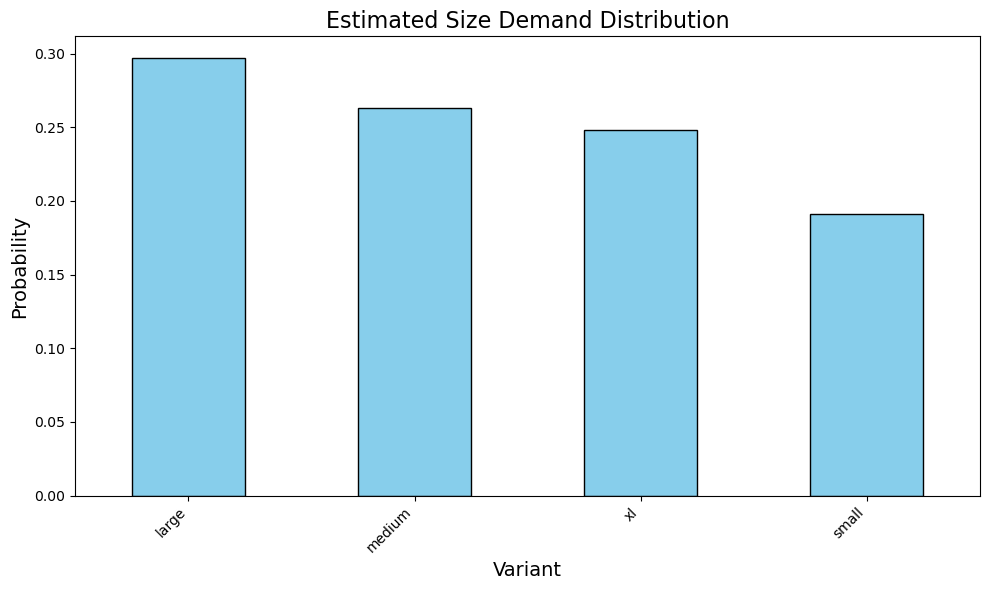

In [11]:

# Sort the probabilities in descending order for visualization
sc_sorted = sc.sort_values(by='p', ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))
sc_sorted['p'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Estimated Size Demand Distribution', fontsize=16)
plt.xlabel('Variant', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()